Nauczmy się stosować \textbf{analizę składowych głównych} (ang. Principal Component Analysis - PCA) na przykładzie zbioru składającego się z 9 argumentów. Spróbujmy zredukować jego wymiarowość, tracąc przy tym jak najmniej informacji.

Argumentami w tym zbiorze jest współczynnik załamania światła oraz udział poszczególnych pierwiastków chemicznych w składzie siedmiu typów szkła, m.in. przeznaczonego do okien w budynkach, okien samochodowych, pojemników, zastawy stołowej lub lamp. 

Argumenty:
\begin{itemize}
\item współczynnik załamania światła: [1.51115, 1.53393],
\item Na (sód): [10.73, 17.38],
\item Mg (magnez): [0.0, 4.49],
\item Al (glin): [0.29, 3.5],
\item Si (krzem): [69.81, 75.41],
\item K (potas): [0.0, 6.21],
\item Ca (wapń): [5.43, 16.19],
\item Ba (bar): [0.0, 3.15],
\item Fe (żelazo): [0.0, 0.51].
\end{itemize}

Wczytajmy teraz niezbędne biblioteki oraz pobierzmy zbiór danych, omijając nagłówek. W ostatniej kolumnie znajduje się output, czyli typ szkła.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.model_selection import train_test_split

data = np.loadtxt('glass.csv', delimiter=',', skiprows=1)
X = data[:, :-1]
# output w pliku jest ma zakres {1, 2, ..., 7}, zmieńmy go na
# {0, 1, ..., 6}
y = data[:, -1] - 1
np.random.seed(3)

# podzielmy od razu dane na zbiór treningowy i testowy w stosunku 70%/30%.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3)

In [2]:
pca = PCA(n_components=3)
pca.fit(X_train)

PCA(n_components=3)

Dowiedzmy się teraz, ile % wariancji wyjściowych zmiennych wyjaśniły nam 3 pierwsze składowe.

In [3]:
print(f'''Trzy poszczególne składowe wyjaśniają {pca.explained_variance_ratio_} zmienności wyjściowych danych,
co daje w sumie {(np.sum(pca.explained_variance_ratio_) * 100.0):.3f}%.''') # zaokrąglenie do 3 wartości po przecinku

Trzy poszczególne składowe wyjaśniają [0.45521751 0.27847639 0.12498405] zmienności wyjściowych danych,
co daje w sumie 85.868%.


Całkiem dobry wynik! Już 3 składowe wyjaśniły prawie 86% zmienności wyjściowego modelu, który składał się przecież z 9 argumentów. Ale może chcemy teraz nie tyle wybrać konkretną liczbę składowych, ile wybrać tyle składowych, by łączny procent wyjaśnianych przez nie zmienności był co najmniej równy np. 95%?

In [4]:
pca = PCA()
pca.fit(X_train)

# Stwórzmy tablicę, która będzie mówiła % zmienności wyjściowego modelu wyjaśnia n składowych głównych.
total_sum = np.cumsum(pca.explained_variance_ratio_)
print(total_sum)

[0.45521751 0.7336939  0.85867795 0.95917883 0.98387546 0.99845867
 0.99945661 0.99999985 1.        ]


Jak widzimy potrzebne są nam co najmniej 4 składowe, aby wyjaśnić więcej niż 95% zmienności danych. Możemy też zautomatyzować ten wybór:

In [5]:
components = np.argmax(total_sum >= 0.95) + 1
# argmax wybierze pierwszą współrzędną, która przyjmuje wartość True.

Przeprowadźmy zatem analizę składowych głównych dla 4 składowych.

In [6]:
pca = PCA(n_components=components)
X_pca = pca.fit_transform(X_train)
np.sum(pca.explained_variance_ratio_)

0.9591788323074883

Zgodnie z oczekiwaniami, wyjaśniamy prawie 96% zmienności danych. Pytanie brzmi: jak wybrać liczbę składowych? Jedną z powszechnie stosowanych metod jest stworzenie \textbf{wykresu osypiska} (ang. elbow method). Polega ona na tym, że bierzemy składowe aż do momentu, w którym wykres ten "załamuje się". Nie zawsze jest to takie oczywiste... Sprawdźmy, jak to wygląda w praktyce.

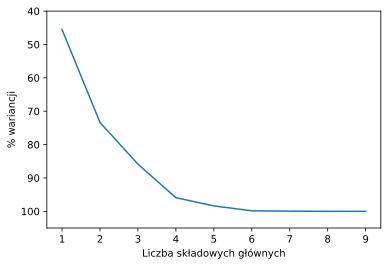

In [7]:
%config InlineBackend.figure_format = 'svg'
arguments = np.arange(1, X[0].size + 1)
fig, ax = plt.subplots()
ax.plot(arguments, total_sum * 100)
ax.set_ylim(105, 40)
ax.set_xlabel('Liczba składowych głównych')
ax.set_ylabel('% wariancji')
plt.show()

Z wykresu osypiska wnioskujemy, że powinniśmy wziąć 4 składowe (w ostateczności 6).

Gdy mamy do czynienia z naprawdę dużym zbiorem danych, który nie mieści się w pamięci komputera, możemy skorzystać z metody \textit{Incremental PCA}. Dzieli ona dane na batche (minipróbki, minipaczki; mieliśmy z nimi już do czynienia przy metodach gradientowych), dzięki czemu jesteśmy w stanie przetworzyć bardziej skomplikowany zbiór danych. W zwykłym PCA wykonuje się działania na macierzach dla całego zbioru danych jednocześnie. \par Na koniec zobaczymy, jak duży jest błąd przy porównaniu metody PCA i Incremental PCA dla naszego zbioru danych, przy wykorzystaniu 4 składowych głównych.  

In [8]:
in_pca = IncrementalPCA(n_components=4, batch_size=10) # możemy regulować rozmiar batcha
X_in_pca = in_pca.fit_transform(X_train)
error = np.abs(np.abs(X_pca) - np.abs(X_in_pca)).mean()
print(error)

0.009143619263485473


Jak widzimy, średni błąd dla naszych danych nie jest wielki.

Spróbujmy teraz dokonać wizualizacji danych przed i po zastosowaniu PCA.

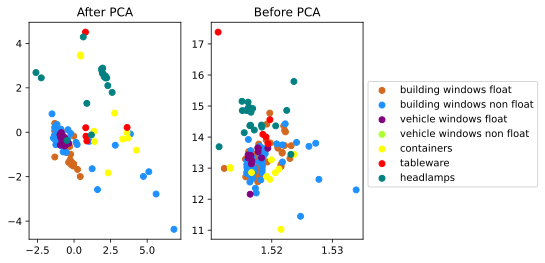

In [9]:
colors = ['chocolate', 'dodgerblue', 'purple',
          'greenyellow', 'yellow', 'red', 'teal']

targets = np.arange(0, 7, 1)
# 2 wykresy ułożone w jednym wierszu
fig, (ax1, ax2) = plt.subplots(1, 2)
for color, i, type_of_glass in zip(colors, targets, y_train):
    ax1.set_title('After PCA')
    ax1.scatter(X_pca[y_train == i, 0],
                X_pca[y_train == i, 1],
                color=color)

    ax2.set_title('Before PCA')
    ax2.scatter(X_train[y_train == i, 0],
                X_train[y_train == i, 1],
                color=color)
# legenda i jej lokalizacja
# poszczególne punkty to typy szkła
plt.legend(['building windows float',
            'building windows non float',
            'vehicle windows float',
            'vehicle windows non float',
            'containers',
            'tableware',
            'headlamps'], 
            bbox_to_anchor=(1.0, 0.75))
plt.show()

Wyświetliliśmy dwie pierwsze składowe w przypadku PCA oraz dwa wybrane argumenty z wyjściowego zbioru (współczynnik załamania światła oraz sód). Nieco łatwiej jest w tym przypadku rozdzielić poszczególne grupy po zastosowaniu PCA. \par Zauważmy, że wciąż nie użyliśmy zbioru testowego. Po co nam był on potrzebny? To jest moment, w którym należy zdać sobie sprawę z jednej rzeczy. Gdy używamy modeli uczenia nadzorowanego, na początku zapominamy o istnieniu zbioru testowego. Znaczy to tyle, że ZAZWYCZAJ dobieramy wszelkie parametry standaryzacji / współczynników PCA / innych przekształceń danych \textbf{jedynie na podstawie zbioru treningowego}, a gotowe współczynniki aplikujemy do zbioru testowego. Potem, gdy sprawdzamy zbiór testowy, przekształcamy dane na podstawie parametrów wyznaczonych przy pomocy zbioru treningowego. Zaaplikujmy teraz wytrenowane PCA do zbioru testowego:

In [10]:
test_PCA = pca.transform(X_test)

print('Zbiór testowy przed PCA:')
for vec in X_test:
    print([f"{arg:.3f}" for arg in vec])

print('Zbiór testowy po PCA')
for vec in test_PCA:
    print([f"{arg:.3f}" for arg in vec])

Zbiór testowy przed PCA:
['1.515', '14.008', '2.681', '3.500', '69.888', '1.683', '5.871', '2.199', '0.000']
['1.516', '12.791', '3.610', '1.619', '72.968', '0.640', '8.066', '0.000', '0.133']
['1.519', '14.993', '0.781', '1.741', '72.498', '0.000', '9.949', '0.000', '0.000']
['1.517', '13.483', '3.480', '1.709', '72.520', '0.621', '7.991', '0.000', '0.000']
['1.516', '13.091', '3.592', '1.519', '73.097', '0.671', '7.829', '0.000', '0.000']
['1.519', '13.490', '3.480', '1.349', '71.949', '0.553', '9.002', '0.000', '0.000']
['1.516', '13.882', '1.778', '1.789', '73.097', '0.000', '8.669', '0.759', '0.000']
['1.516', '13.250', '3.448', '1.430', '73.170', '0.609', '7.862', '0.000', '0.000']
['1.519', '13.889', '3.529', '1.320', '71.809', '0.509', '8.776', '0.110', '0.000']
['1.527', '11.229', '0.000', '0.771', '73.209', '0.000', '14.684', '0.000', '0.000']
['1.517', '13.297', '3.641', '1.529', '72.532', '0.652', '8.034', '0.000', '0.148']
['1.517', '12.858', '3.579', '1.311', '72.610', '0

Co teraz? Tak przygotowany zbiór możemy analizować dalej, np. stosując techniki uczenia nadzorowanego. PCA jest zazwyczaj narzędziem wstępnym, przygotowującym nasz zbiór do dalszych prac.

\textbf{Źródła:} Zbiór danych Glass Identification pochodzi z USA Forensic Science Service (archive.ics.uci.edu); dokumentacja Scikit-Learn

[[ -2.08797401  19.78398451 -10.51350198]
 [  4.08983723  11.7563553   13.28941985]
 [  5.30560118  10.43856091  -2.34825945]
 ...
 [  5.69826385  19.91897244   3.80695481]
 [  9.23848023   3.99969142   9.72408056]
 [  0.75961327   3.76414228  14.03920665]]
[[ 4.08983723 11.7563553  13.28941985]
 [ 5.30560118 10.43856091 -2.34825945]
 [ 6.04878497  7.93167406 12.13621532]
 ...
 [ 5.69826385 19.91897244  3.80695481]
 [ 9.23848023  3.99969142  9.72408056]
 [ 0.75961327  3.76414228 14.03920665]]


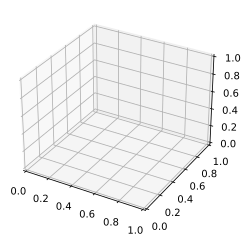

In [41]:
from sklearn.datasets import make_swiss_roll
X, color = make_swiss_roll(1000,noise=0.2)
print(X)
print(X[1:,])

ax=plt.axes(projection="3d")
#ax.scatter3D(X[0],X[,1],X[,2],color=color)
#plt.show()